# Ion Composition

```{admonition} WIP
This page is currently a **work in progress**, meaning it likely has incomplete explanations and some non-functional code/links/ect.  Please be patient!

If you think you can help, please consider [contributing](https://github.com/amisr/amisr_user_manual#contributing-material).
```

The standard ISR fitting performed on AMISR data includes estimation of the compositions of different ion species in the ionosphere.  This tutorial demonstrates how to access and plot these data.

In [3]:
import numpy as np
import h5py
import os
import urllib.request
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

Download files that will be used in this tutorial.

In [2]:
# Download the file that we need to run these examples
filename = '../../data/20200207.001_lp_5min-fitcal.h5'

if not os.path.exists(filename):
    url='https://data.amisr.com/database/dbase_site_media/PFISR/Experiments/20200207.001/DataFiles/20200207.001_lp_5min-fitcal.h5'

    print('Downloading data file...')
    urllib.request.urlretrieve(url, filename)

    print('...Done!')


Read in relevant parameters from the data file.  Fractional ion composition is contained within the [Fits Array](fits).  Note that the last element in the fourth dimension of [Fits](fits) refers to electrons, so you only need to read in the other elements in this dimension.

In [7]:
with h5py.File(filename, 'r') as h5:
    beamcodes = h5['BeamCodes'][:]
    bidx = np.argmax(beamcodes[:,2])
    utime = h5['Time/UnixTime'][:,0]
    alt = h5['Geomag/Altitude'][:]
    comp = h5['FittedParams/Fits'][:,:,:,:-1,0]
    ionmass = h5['FittedParams/IonMass'][:]
    
time = utime.astype('datetime64[s]')

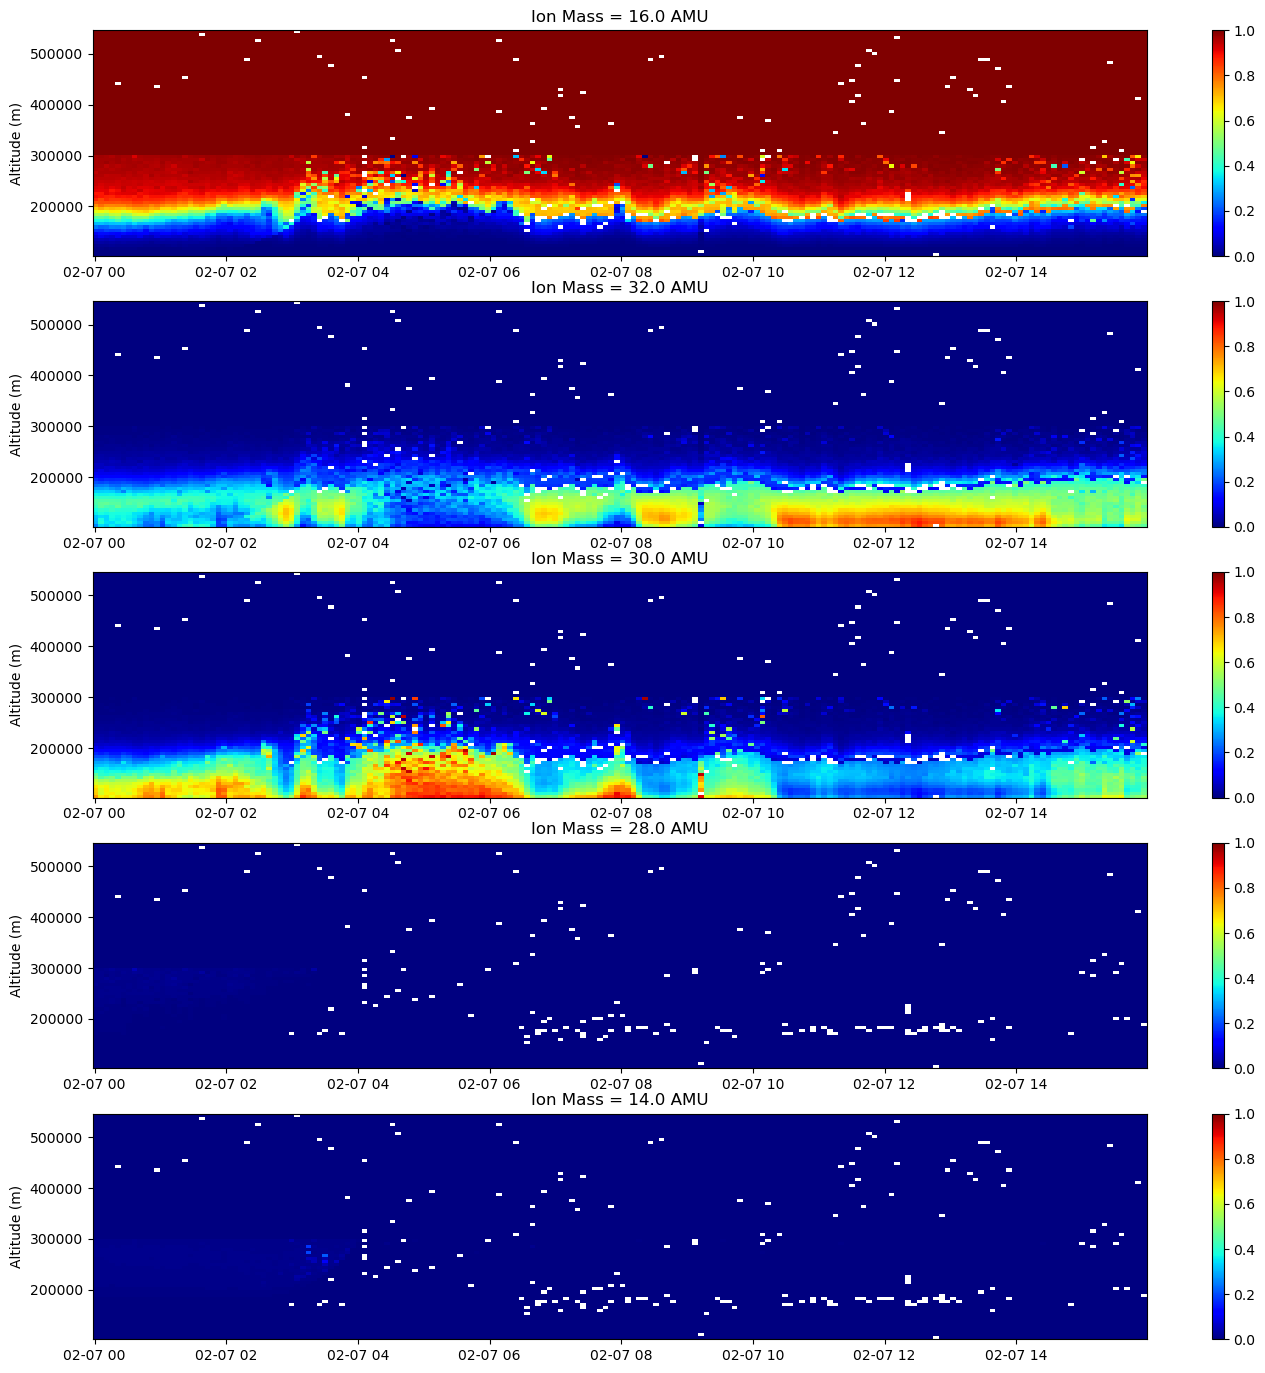

In [8]:
fig = plt.figure(figsize=(17,17))
gs = gridspec.GridSpec(len(ionmass),1)

# finite_alt = np.isfinite(alt[10,:])

for i in range(len(ionmass)):
    ax = fig.add_subplot(gs[i])
    c = ax.pcolormesh(time, alt[bidx,:], comp[:,bidx,:,i].T, cmap='jet', vmin=0., vmax=1.)
    ax.set_title(f'Ion Mass = {ionmass[i]} AMU')
    fig.colorbar(c)
    ax.set_ylabel('Altitude (m)')

The hard step function at 300000 m that is particularly obvious in the O+ panel (top row, Ion Mass = 16 AMU) is due to the fitter assuming a purely O+ atmosphere above 300 km.  This is a default setting for many fitted data files and is generally a fairly safe assumption (note how composition of most other species goes to zero long before this altitude).

## Ion Density
The absolute density of each ion species (rather than its fractional composition) can by found by multiplying the fractional composition by the electron density.  This works because all the relevant ions in the ionosphere have a charge state of +1 (they've only lost a single electron when ionized) and the bulk plasma must be quasineutral, so in total there are the same number of ion molecules in the plasma as electrons.

(188, 11, 74) (188, 11, 74, 6) (5,) (11, 74)


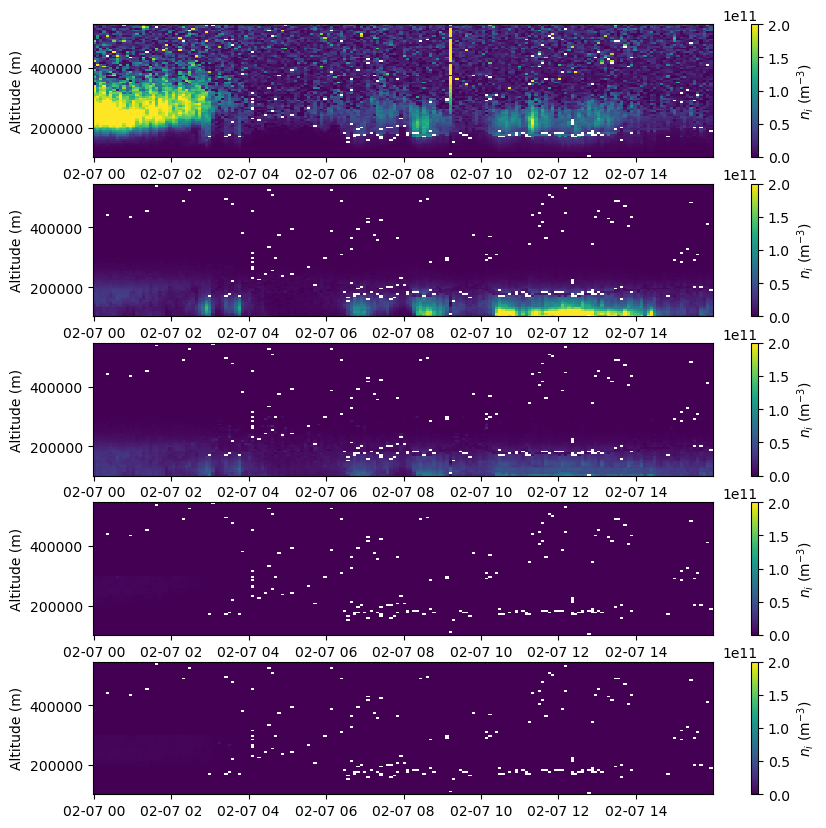

In [12]:
with h5py.File(filename, 'r') as h5:
    ne = h5['FittedParams/Ne'][:]
    frac = h5['FittedParams/Fits'][:,:,:,:,0]
    ion_mass = h5['FittedParams/IonMass'][:]
    alt = h5['Geomag/Altitude'][:]

# Calculate ion densities
ni = np.expand_dims(ne,axis=-1)*frac[:,:,:,:-1]

fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(len(ion_mass),1)
for i in range(len(ion_mass)):
    ax = fig.add_subplot(gs[i])
    c = ax.pcolormesh(time, alt[bidx,:], ni[:,bidx,:,i].T, vmin=0., vmax=2.e11)
    fig.colorbar(c, label=r'$n_i$ (m$^{-3}$)')
    ax.set_ylabel('Altitude (m)')
